## Part 2: Introduction of GAT Network



In [1]:
# Find the CUDA version PyTorch was installed with
!python -c "import torch; print(torch.version.cuda)"

11.8


In [2]:
# PyTorch version
!python -c "import torch; print(torch.__version__)"

2.0.1+cu118


In [3]:
!pip install torch_geometric

# Optional dependencies:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.1+cu118.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 11.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=d7df3d44056716101101d63ce0b33d0631c29a8876695ee8bf2aba99a58028b9
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 116.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 113.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 114.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 71.0 MB/s eta 0:00:00


In [4]:
# # Use the above information to fill in the http address below
# %%capture
# !pip install ogb pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
# !pip install torch-geometric

In [5]:
import torch
import pickle
import random as rd
import numpy as np
import scipy.sparse as sp
from scipy.io import loadmat
import copy as cp
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score, average_precision_score
from collections import defaultdict
import matplotlib.pyplot as plt


def sparse_to_adjlist(sp_matrix, filename):
	"""
	Transfer sparse matrix to adjacency list
	:param sp_matrix: the sparse matrix
	:param filename: the filename of adjlist
	"""
	# add self loop
	homo_adj = sp_matrix + sp.eye(sp_matrix.shape[0])
	# create adj_list
	adj_lists = defaultdict(set)
	edges = homo_adj.nonzero()
	for index, node in enumerate(edges[0]):
		adj_lists[node].add(edges[1][index])
		adj_lists[edges[1][index]].add(node)
	with open(filename, 'wb') as file:
		pickle.dump(adj_lists, file)
	file.close()

In [9]:
!unzip '/content/YelpChi.zip'


Archive:  /content/YelpChi.zip
  inflating: yelp_homo_adjlists.pickle  
  inflating: yelp_rsr_adjlists.pickle  
  inflating: yelp_rtr_adjlists.pickle  
  inflating: yelp_rur_adjlists.pickle  
  inflating: YelpChi.mat             
  inflating: __MACOSX/._YelpChi.mat  


In [10]:
# (COLAB) Upload the YelpChi.mat file into the session directory, then copy
#         the path into the 'prefix' variable

prefix = '/content/'

data_file = loadmat(prefix +  'YelpChi.mat')

labels = data_file['label'].flatten()
features = data_file['features'].todense().A

yelp_homo = data_file['homo'] #C
sparse_to_adjlist(yelp_homo, prefix + 'yelp_homo_adjlists.pickle') #C



# load the preprocessed adj_lists
with open(prefix + 'yelp_homo_adjlists.pickle', 'rb') as file:
    homogenous = pickle.load(file)
file.close()


In [11]:
# Prelim network EDA
import networkx as nx


In [12]:
#Data needs to be translated into torch tensors when using pytorch geometric
print(f'features dtype = {features.dtype}, \n' +
      f'label dtype = {labels.dtype}')


features dtype = float64, 
label dtype = int64


In [13]:
# Same split of data into test and train
from sklearn.model_selection import train_test_split
split = 0.2
indices = np.arange(len(features))

xtrain, xtest, ytrain, ytest, idxtrain, idxtest = train_test_split(features,
                                                                   labels,indices,
                                                                   stratify=labels,
                                                                   test_size = split,
                                                                   random_state = 99)



In [14]:
g = nx.Graph(homogenous)
print(f'Number of nodes: {g.number_of_nodes()}')
print(f'Number of edges: {g.number_of_edges()}')
print(f'Average node degree: {len(g.edges) / len(g.nodes):.2f}')


Number of nodes: 45954
Number of edges: 3892933
Average node degree: 84.71


In [23]:
# Convert to torch geometric datatype
from torch_geometric.utils.convert import from_networkx

data = from_networkx(g)
data.x = torch.tensor(features).float()
data.y = torch.tensor(labels)
data.num_node_features = data.x.shape[-1]
data.num_classes = 1 #binary classification

A = set(range(len(labels)))
data.train_mask = torch.tensor([x in idxtrain for x in A])
data.test_mask = torch.tensor([x in idxtest for x in A])

In [24]:
import torch_geometric.transforms as T
from torch_geometric.transforms import NormalizeFeatures

transform = NormalizeFeatures()
transform(data)

data

Data(edge_index=[2, 7739912], num_nodes=45954, x=[45954, 32], y=[45954], num_node_features=32, num_classes=1, train_mask=[45954], test_mask=[45954])

In [25]:
from torch_geometric.nn import GCNConv, Linear
import torch.nn.functional as F


In [26]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_layers = 64):
        super().__init__()
        torch.manual_seed(2022)
        self.conv1 = GCNConv(data.num_node_features, hidden_layers)
        self.conv2 = GCNConv(hidden_layers, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return torch.sigmoid(x)


In [28]:
from sklearn.metrics import roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = GCN()
model.to(device)
data_gpu = data.to(device)

lr = 0.01
epochs = 100

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
criterion = torch.nn.BCELoss()

losses = []
for e in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data_gpu)
    #for discussion on why masks is applied here, see: https://stackoverflow.com/questions/69019682/training-mask-not-used-in-pytorch-geometric-when-inputting-data-to-train-model
    #loss
    loss = criterion(out[data_gpu.train_mask], data.y[data_gpu.train_mask].reshape(-1,1).float())
    loss.backward()
    losses.append(loss.item())

    optimizer.step()

    #accuracy
    ypred = model(data_gpu)
    pred = data.y[data_gpu.test_mask].clone().cpu().detach().numpy()
    true = ypred[data_gpu.test_mask].clone().cpu().detach().numpy()
    acc = roc_auc_score(pred,true)

    print(f'Epoch {e} | Loss {loss:6.2f} | Accuracy = {100*acc:6.3f}% | # True Labels = {ypred.round().sum()}')


cuda
Epoch 0 | Loss   0.71 | Accuracy = 63.214% | # True Labels = 0.0
Epoch 1 | Loss   0.68 | Accuracy = 73.427% | # True Labels = 0.0
Epoch 2 | Loss   0.64 | Accuracy = 70.367% | # True Labels = 0.0
Epoch 3 | Loss   0.62 | Accuracy = 70.794% | # True Labels = 0.0
Epoch 4 | Loss   0.59 | Accuracy = 71.248% | # True Labels = 0.0
Epoch 5 | Loss   0.56 | Accuracy = 70.741% | # True Labels = 0.0
Epoch 6 | Loss   0.53 | Accuracy = 72.137% | # True Labels = 0.0
Epoch 7 | Loss   0.50 | Accuracy = 72.591% | # True Labels = 0.0
Epoch 8 | Loss   0.48 | Accuracy = 72.275% | # True Labels = 0.0
Epoch 9 | Loss   0.45 | Accuracy = 71.049% | # True Labels = 0.0
Epoch 10 | Loss   0.43 | Accuracy = 74.150% | # True Labels = 0.0
Epoch 11 | Loss   0.42 | Accuracy = 70.282% | # True Labels = 0.0
Epoch 12 | Loss   0.41 | Accuracy = 71.325% | # True Labels = 0.0
Epoch 13 | Loss   0.40 | Accuracy = 71.103% | # True Labels = 0.0
Epoch 14 | Loss   0.40 | Accuracy = 73.425% | # True Labels = 0.0
Epoch 15 | Loss

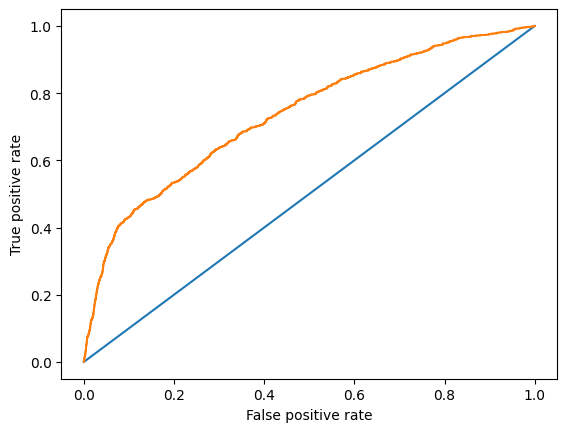

In [29]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(pred,true)

plt.figure(1)
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [31]:
data.cpu()

Data(edge_index=[2, 7739912], num_nodes=45954, x=[45954, 32], y=[45954], num_node_features=32, num_classes=1, train_mask=[45954], test_mask=[45954])

In [32]:
#GATConv does not scale by design...
#https://github.com/pyg-team/pytorch_geometric/issues/527
#Single dense graph so using NeighborLoader (where DataLoader is for multi-graph problems)
from torch_geometric.loader import NeighborLoader

batch_size = 128
loader = NeighborLoader(
    data.cpu(),
    # Sample 1000 neighbors for each node for 2 iterations
    num_neighbors=[1000]*2,
    # Use a batch size for sampling training nodes
    batch_size=batch_size,
    input_nodes=data.train_mask,
)

sampled_data = next(iter(loader))
print(f'Checking that batch size is {batch_size}: {batch_size == sampled_data.batch_size}')
print(f'Percentage fraud in batch: {100*sampled_data.y.sum()/len(sampled_data.y):.4f}%')
sampled_data

Checking that batch size is 128: True
Percentage fraud in batch: 10.0280%


Data(edge_index=[2, 29163], num_nodes=7489, x=[7489, 32], y=[7489], num_node_features=32, num_classes=1, train_mask=[7489], test_mask=[7489], n_id=[7489], e_id=[29163], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[128], batch_size=128)

In [33]:
#As we are using batched data, important to also have batchnorm in network

from torch_geometric.nn import GATConv
import torch.nn as nn

class GAT(torch.nn.Module):
    def __init__(self, hidden_layers=32, heads=1, dropout_p=0.0):
        super().__init__()
        torch.manual_seed(2022)
        self.conv1 = GATConv(data.num_node_features, hidden_layers, heads, dropout=dropout_p)
        self.bn1 = nn.BatchNorm1d(hidden_layers*heads)
        self.conv2 = GATConv(hidden_layers * heads, 1, dropout=dropout_p)

    def forward(self, data, dropout_p=0.0):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return torch.sigmoid(x)


In [35]:
lr = 0.01
epochs = 20

model = GAT(hidden_layers = 64,heads=2)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=5e-4)
criterion = torch.nn.BCELoss()

losses = []
for e in range(epochs):
    epoch_loss = 0.
    for i, sampled_data in enumerate(loader):
        sampled_data.to(device)

        model.train()
        optimizer.zero_grad()
        out = model(sampled_data)
        loss = criterion(out[sampled_data.train_mask], sampled_data.y[sampled_data.train_mask].reshape(-1,1).float())
        loss.backward()
        epoch_loss += loss.item()

        optimizer.step()

        #accuracy
        ypred = model(sampled_data)
        pred = sampled_data.y[sampled_data.test_mask].clone().cpu().detach().numpy()
        true = ypred[sampled_data.test_mask].clone().cpu().detach().numpy()
        acc = roc_auc_score(pred,true)

    losses.append(epoch_loss/batch_size)

    print(f'Epoch {e} | Loss {epoch_loss:6.2f} | Accuracy = {100*acc:6.3f}% | # True Labels = {ypred.round().sum()}')


Epoch 0 | Loss  81.38 | Accuracy = 82.011% | # True Labels = 40.0
Epoch 1 | Loss  76.29 | Accuracy = 84.854% | # True Labels = 51.0
Epoch 2 | Loss  75.19 | Accuracy = 86.839% | # True Labels = 53.0
Epoch 3 | Loss  74.63 | Accuracy = 82.275% | # True Labels = 51.0
Epoch 4 | Loss  74.38 | Accuracy = 86.706% | # True Labels = 46.0
Epoch 5 | Loss  74.12 | Accuracy = 83.796% | # True Labels = 55.0
Epoch 6 | Loss  74.00 | Accuracy = 83.333% | # True Labels = 55.0
Epoch 7 | Loss  73.89 | Accuracy = 85.582% | # True Labels = 55.0
Epoch 8 | Loss  73.90 | Accuracy = 84.325% | # True Labels = 52.0
Epoch 9 | Loss  73.88 | Accuracy = 85.516% | # True Labels = 49.0
Epoch 10 | Loss  73.72 | Accuracy = 86.772% | # True Labels = 47.0
Epoch 11 | Loss  73.70 | Accuracy = 84.788% | # True Labels = 47.0
Epoch 12 | Loss  73.50 | Accuracy = 83.598% | # True Labels = 50.0
Epoch 13 | Loss  73.69 | Accuracy = 84.590% | # True Labels = 52.0
Epoch 14 | Loss  73.62 | Accuracy = 83.929% | # True Labels = 55.0
Epoch

In [37]:
data.to(device)
ypred = model(data)
pred = data.y[data.test_mask].clone().cpu().detach().numpy()
true = ypred[data.test_mask].clone().cpu().detach().numpy()
acc = roc_auc_score(pred,true)
print(f"Final model accuracy for GAT is : {100*acc:.4f}%")

Final model accuracy for GAT is : 93.1078%


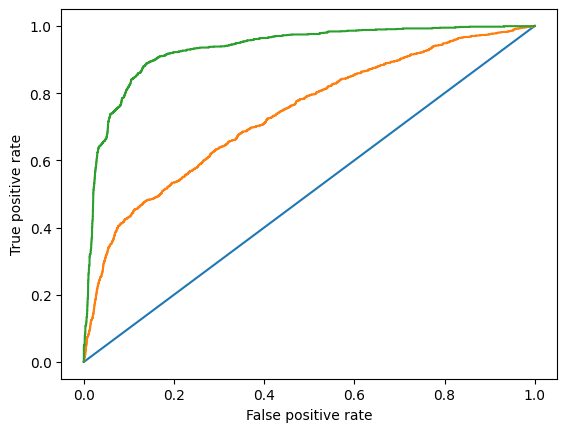

In [38]:

fpr2, tpr2, _ = roc_curve(pred,true)

plt.figure(1)
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)
plt.plot(fpr2, tpr2)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [39]:
# Additional parameters to change:
#  - number of epochs
#  - number of hidden layers
#  - number of heads
#  - dropout probability
#  - learning rate (optimizer)
#  - weight decay rate (optimizer)


### Advanced:

GATv2Conv —> https://arxiv.org/pdf/2105.14491.pdf

In [40]:
from torch_geometric.nn import GATv2Conv

class GATv2(torch.nn.Module):
    def __init__(self, hidden_layers=32, heads=1, dropout_p=0.0):
        super().__init__()
        torch.manual_seed(2022)
        self.conv1 = GATv2Conv(data.num_node_features, hidden_layers, heads, dropout=dropout_p)
        self.bn1 = nn.BatchNorm1d(hidden_layers*heads)
        self.conv2 = GATv2Conv(hidden_layers * heads, 1, dropout=dropout_p)

    def forward(self, data, dropout_p=0.0):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return torch.sigmoid(x)


In [42]:
lr = 0.01
epochs = 20

model = GATv2(hidden_layers = 64,heads=1)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=5e-4)


criterion = torch.nn.BCELoss()

losses = []
for e in range(epochs):
    epoch_loss = 0.
    for i, sampled_data in enumerate(loader):
        sampled_data.to(device)

        model.train()
        optimizer.zero_grad()
        out = model(sampled_data)
        loss = criterion(out[sampled_data.train_mask], sampled_data.y[sampled_data.train_mask].reshape(-1,1).float())
        loss.backward()
        epoch_loss += loss.item()

        optimizer.step()

        #accuracy
        ypred = model(sampled_data)
        pred = sampled_data.y[sampled_data.test_mask].clone().cpu().detach().numpy()
        true = ypred[sampled_data.test_mask].clone().cpu().detach().numpy()
        acc = roc_auc_score(pred,true)

    losses.append(epoch_loss/batch_size)

    print(f'Epoch {e} | Loss {loss:6.2f} | Accuracy = {100*acc:6.3f}% | # True Labels = {ypred.round().sum()}')


Epoch 0 | Loss   0.44 | Accuracy = 85.913% | # True Labels = 26.0
Epoch 1 | Loss   0.44 | Accuracy = 83.664% | # True Labels = 29.0
Epoch 2 | Loss   0.43 | Accuracy = 83.201% | # True Labels = 32.0
Epoch 3 | Loss   0.45 | Accuracy = 83.267% | # True Labels = 34.0
Epoch 4 | Loss   0.43 | Accuracy = 83.664% | # True Labels = 39.0
Epoch 5 | Loss   0.43 | Accuracy = 86.243% | # True Labels = 31.0
Epoch 6 | Loss   0.45 | Accuracy = 79.894% | # True Labels = 35.0
Epoch 7 | Loss   0.43 | Accuracy = 85.516% | # True Labels = 37.0
Epoch 8 | Loss   0.45 | Accuracy = 79.101% | # True Labels = 36.0
Epoch 9 | Loss   0.42 | Accuracy = 86.045% | # True Labels = 31.0
Epoch 10 | Loss   0.43 | Accuracy = 84.193% | # True Labels = 31.0
Epoch 11 | Loss   0.43 | Accuracy = 80.886% | # True Labels = 33.0
Epoch 12 | Loss   0.43 | Accuracy = 82.275% | # True Labels = 34.0
Epoch 13 | Loss   0.42 | Accuracy = 82.606% | # True Labels = 36.0
Epoch 14 | Loss   0.45 | Accuracy = 84.061% | # True Labels = 33.0
Epoch

In [45]:
data.to(device)
ypred = model(data)
pred = data.y[data.test_mask].clone().cpu().detach().numpy()
true = ypred[data.test_mask].clone().cpu().detach().numpy()
acc = roc_auc_score(pred,true)
print(f"Final model accuracy for GATv2 is : {100*acc:.4f}%")

Final model accuracy for GATv2 is : 92.3394%
